In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax import serialization
import optax

from SmoothNF import SmoothNormalizingFlow 

import numpy as np
import matplotlib.pyplot as plt
import h5py

from functools import partial
from typing import Sequence

import timeit
import pickle


from jax.config import config; #config.update("jax_enable_x64", True)

# physics stuff
import pylhe

# Madjax
import madjax

In [2]:
key = jax.random.PRNGKey(42)

batch_size = 100
num_epochs = 300
num_warm_up_epochs = 10
steps_per_epoch = 75 #20000 // batch_size

learning_rate = 0.5e-4

eps_border = 1.0e-10


# Setup MadJax

In [3]:

E_cm = 500.
config_name  = "ee_ttbar_bqq_bqq"
process_name = "Matrix_1_epem_ttx_t_budx_tx_bxdux"
nDimPS=14

mj = madjax.MadJax(config_name=config_name)
matrix_element = mj.matrix_element(E_cm=E_cm, process_name=process_name, return_grad=False, do_jit=False)
jacobian = mj.jacobian(E_cm=E_cm, process_name=process_name, do_jit=False)
me_and_jac = mj.matrix_element_and_jacobian(E_cm=E_cm, process_name=process_name)
ps_gen = mj.phasespace_generator(E_cm=E_cm, process_name=process_name)({})
ps_vec = mj.phasespace_vectors(E_cm=E_cm, process_name=process_name)

external_params={}

sigma_smear=0.1

In [4]:
def scalar_rv_from_ps_point(ps_point, E_cm):
    i_rv, i_wt = ps_gen.invertKinematics(E_cm, [madjax.phasespace.vectors.Vector(p) for p in ps_point])
    
    return jnp.array(i_rv)

vector_rv_from_ps_point = jax.jit(jax.vmap(scalar_rv_from_ps_point, in_axes=(0,None)), static_argnums=1)

In [5]:
def get_scalar_log_me(params):
    _eps = 1.0e-10
    def func(rv):
        me_val, jac_val = me_and_jac(params, rv)
        return jnp.log(me_val)+ jnp.log(jac_val)
        #return jnp.log(matrix_element(params, rv)+_eps)+jnp.log(jacobian(params, rv)+_eps)
    return func

scalar_log_me = get_scalar_log_me(params={})
vector_log_me = jax.vmap(get_scalar_log_me(params={}))

grad_scalar_log_me = jax.grad(get_scalar_log_me(params={}))
grad_vector_log_me = jax.vmap(jax.grad(get_scalar_log_me(params={})))


scalar_log_me_jit = jax.jit(get_scalar_log_me(params={}))
vector_log_me_jit = jax.jit(jax.vmap(get_scalar_log_me(params={})))

grad_scalar_log_me_jit = jax.jit(jax.grad(get_scalar_log_me(params={})))
grad_vector_log_me_jit = jax.jit(jax.vmap(jax.grad(get_scalar_log_me(params={}))))

In [6]:
import timeit

def prejit_matrix_elements():
    init_data = 0.9*jnp.ones((10,nDimPS))
    
    start_time = timeit.default_timer()
    scalar_log_me_jit(init_data[0])
    elapsed = timeit.default_timer() - start_time
    print("scalar_log_me time", elapsed,"\n")
    
    start_time = timeit.default_timer()
    vector_log_me_jit(init_data)
    elapsed = timeit.default_timer() - start_time
    print("vector_log_me time", elapsed,"\n")
    

    start_time = timeit.default_timer()
    grad_scalar_log_me_jit(init_data[0])
    elapsed = timeit.default_timer() - start_time
    print("grad_scalar_log_me time", elapsed,"\n")
    
    start_time = timeit.default_timer()
    grad_vector_log_me_jit(init_data)
    elapsed = timeit.default_timer() - start_time
    print("grad_vector_log_me time", elapsed,"\n")
    
if True:
    prejit_matrix_elements()

scalar_log_me time 7.873381333425641 

vector_log_me time 11.70508507732302 

grad_scalar_log_me time 35.228928002528846 

grad_vector_log_me time 71.31747904140502 



# LHE Event Manipulation

In [7]:
# get LHE events generator
lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")

In [8]:
def lhe_event_to_ps_point(event):
    _particles = []
    for p in event.particles:
        #print(p.id, p.status, p.px, p.py, p.pz, p.e)
        if p.status==-1 or p.status==1:
            _particles += [[p.e, p.px, p.py, p.pz]]
    return jnp.array(_particles)

def get_multiple_lhe_event_to_ps_point(lhe_event_generator, n_events):
    _evts=[]
    for i in range(n_events):
        try:
            _ev = lhe_event_generator.__next__()
        except:
            print("No More Events")
            return _evts
        
        _ps = lhe_event_to_ps_point(_ev)
        _evts += [_ps]
    
    return np.array(_evts)

In [ ]:
events = get_multiple_lhe_event_to_ps_point(lhe_events, 10000)
dataset = vector_rv_from_ps_point(events, E_cm)

train_data = dataset[0:8000]
test_data = dataset[8000:]

# Setup Smooth NF

In [41]:
def model1():
    return SmoothNormalizingFlow(num_flows = 4,
                                num_biject = 4,
                                num_in_feat = nDimPS,
                                cond_mlp_width = [[100,100]])


In [10]:

#def force_MSE(x, grad_flow_logprob):
#    grad_logME = grad_vector_log_me(x)
#    return jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)

In [11]:
@jax.jit
def train_step1(state, batch, key):
    def loss_fn(params):
        def _logp(x):
            z, ldj = model1().apply({'params':params}, x, method=model1().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)

        def synth_samp_logp_minus_logME(z):
            x, ldj = model1().apply({'params':params}, z, method=model1().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
        synth_z = jax.random.uniform(key, shape=batch.shape, minval=1.0e-10, maxval=(1.0-1.0e-10))
        reverse_kld_loss = (synth_samp_logp_minus_logME(synth_z)).mean()
                
       
        loss = forward_kld_loss + 0.1*reverse_kld_loss # + 0.001*force_MSE_loss
        return loss
    
   
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)
    
        
    

@jax.jit
def train_step1_only_fkl(state, batch, key):
    def loss_fn(params):
        def _logp(x):
            z, ldj = model1().apply({'params':params}, x, method=model1().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
       
        loss = forward_kld_loss 
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)

In [17]:


@jax.jit
def eval1(params, x, key):
    def eval_model(smoothnf):
        def _logp(x):
            z, ldj = model1().apply({'params':params}, x, method=model1().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)

        def synth_samp_logp_minus_logME(z):
            x, ldj = model1().apply({'params':params}, z, method=model1().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
        
        def _force_MSE_and_cos(x, grad_flow_logprob):
            grad_logME = grad_vector_log_me_jit(x)
            _force = jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)
            
            gme_norm = jnp.sqrt(jnp.square(grad_logME).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1))
            gfl_norm = jnp.sqrt(jnp.square(grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1))
            _cos = jnp.multiply(grad_logME, grad_flow_logprob) / (gme_norm + 1e-10) / (gfl_norm + 1e-10)
            
            return _force, _cos
            
        
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
        synth_z = jax.random.uniform(key, shape=batch.shape, minval=1e-10, maxval=(1.0-1e-10))
        reverse_kld_loss = synth_samp_logp_minus_logME(synth_z).mean()
        
        _, _gradx_logp = model1().apply({'params':params}, batch, method=model1().val_and_gradx_logprob)
        _f, _c = _force_MSE_and_cos(batch, _gradx_logp)
        force_mse = _f.mean()
        cos_loss = _c.mean()
                
        metrics = {'fkld': forward_kld_loss,
                   'rkld': reverse_kld_loss,
                   'force': force_mse,
                   'cos': cos_loss,
                   'loss': forward_kld_loss + 0.1*reverse_kld_loss #+ 0.001*force_loss
                  }
        
        return metrics

    return nn.apply(eval_model, model1())({'params': params})




In [13]:
# lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")
# events = get_multiple_lhe_event_to_ps_point(lhe_events, 10000)
# dataset1 = vector_rv_from_ps_point(events, E_cm)
# train_data1 = dataset1[0:8000]
# test_data1 = dataset1[8000:]

train_data1 = train_data
test_data1 = test_data

rng, key, eval_rng = jax.random.split(key, 3)

#batch_size = 50
#learning_rate = 1e-3
init_data = jnp.ones((batch_size,nDimPS))


#optimizer1 = optax.chain( optax.zero_nans(), optax.adam(learning_rate), optax.zero_nans())

state1_init = train_state.TrainState.create(
      apply_fn=model1().apply,
      params=model1().init(key, init_data)['params'],
      tx=optax.adam(learning_rate),
  )

state1 = state1_init

#prejit:
print("pre-jit model1")
batch = train_data1[np.random.choice(np.arange(len(train_data1)), size = batch_size)]

start_time = timeit.default_timer()
train_step1(state1, batch, key)
elapsed = timeit.default_timer() - start_time
print("train_step1: elapsed time", elapsed,"\n")

start_time = timeit.default_timer()
train_step1_only_fkl(state1, batch, key)
elapsed = timeit.default_timer() - start_time
print("train_step1_norkl: elapsed time", elapsed,"\n")


    

pre-jit model1


2022-02-16 13:45:13.172541: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_train_step1.95661
********************************


train_step1: elapsed time 433.2114608073607 

train_step1_norkl: elapsed time 106.21117999963462 



In [19]:
print("pre-jit eval1")
start_time = timeit.default_timer()
metrics = eval1(state1.params, test_data1, eval_rng)
print('eval1, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f}, CosLoss: {:.4f} \n'.format(
        metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']))
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")

pre-jit eval1
eval1, loss: 12.0944, fwdKLD: 11.0994, revKLD: 9.9503, forceMSE: 740283.4488, CosLoss: 0.0025 

elapsed time 0.3337772646918893 



In [44]:
saved_params1 = []
saved_params1.append(state1.params)

losses1 = []

state1 = state1_init

In [45]:

config.update("jax_debug_nans", True)

# num_epochs = 100
# steps_per_epoch = 75 #20000 // batch_size


for epoch in range(num_epochs):
    print("epoch",epoch)
    start_time = timeit.default_timer()
    
    
    for step in range(steps_per_epoch):
        
        batch = train_data1[np.random.choice(np.arange(len(train_data1)), size = batch_size)]
        rng, key = jax.random.split(rng)
        if epoch < num_warm_up_epochs:
            state1 = train_step1_only_fkl(state1, batch, key)
        else:
            try:
                state_update = train_step1(state1, batch, key)
                state1 = state_update
            except FloatingPointError:
                print("### GRAD FloatingPointError - continue without update")
        
    saved_params1.append(state1.params)
        
    elapsed = timeit.default_timer() - start_time
    print("elapsed time", elapsed)
    
    metrics = eval1(state1.params, test_data1, eval_rng)
    print('eval1 epoch: {}, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f}, CosLoss: {:.4f} \n'.format(
        epoch, metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']))
    
    losses1.append([metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']])

epoch 0
elapsed time 3.425322249531746
eval1 epoch: 0, loss: 7.9545, fwdKLD: 7.2318, revKLD: 7.2278, forceMSE: 740230.8155, CosLoss: 0.0020 

epoch 1
elapsed time 3.3102256329730153
eval1 epoch: 1, loss: 4.0968, fwdKLD: 3.7214, revKLD: 3.7533, forceMSE: 740322.6367, CosLoss: 0.0016 

epoch 2
elapsed time 3.377172000706196
eval1 epoch: 2, loss: 1.6099, fwdKLD: 1.4431, revKLD: 1.6682, forceMSE: 740011.8776, CosLoss: 0.0022 

epoch 3
elapsed time 3.2859939746558666
eval1 epoch: 3, loss: 0.3677, fwdKLD: 0.3098, revKLD: 0.5788, forceMSE: 740162.9219, CosLoss: 0.0019 

epoch 4
elapsed time 3.306285516358912
eval1 epoch: 4, loss: -0.4126, fwdKLD: -0.4091, revKLD: -0.0358, forceMSE: 740284.8222, CosLoss: 0.0018 

epoch 5
elapsed time 3.247436610981822
eval1 epoch: 5, loss: -0.8755, fwdKLD: -0.8477, revKLD: -0.2774, forceMSE: 740306.2694, CosLoss: 0.0020 

epoch 6
elapsed time 3.187380083836615
eval1 epoch: 6, loss: -1.1844, fwdKLD: -1.1476, revKLD: -0.3672, forceMSE: 740305.7329, CosLoss: 0.00

FloatingPointError: invalid value (nan) encountered in div

In [24]:

outfile_name = "results_comp_smoothNF/model1_results.pkl"
outfile = open(outfile_name,'wb')
saved_param_dict = []
for ip in saved_params1:
    ip_dict = serialization.to_state_dict(ip)
    saved_param_dict.append(ip_dict)

outtuple = (saved_param_dict, losses1)
pickle.dump(outtuple, outfile)
outfile.close()

# No RKL

In [42]:
def model2():
    return SmoothNormalizingFlow(num_flows = 4,
                                num_biject = 4,
                                num_in_feat = nDimPS,
                                cond_mlp_width = [[100,100]])

In [26]:
@jax.jit
def train_step2(state, batch, key):
    def loss_fn(params):
        def _logp(x):
            z, ldj = model2().apply({'params':params}, x, method=model2().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
       
        loss = forward_kld_loss 
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)

In [27]:
@jax.jit
def eval2(params, x, key):
    def eval_model(smoothnf):
        def _logp(x):
            z, ldj = model2().apply({'params':params}, x, method=model2().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)

        def synth_samp_logp_minus_logME(z):
            x, ldj = model2().apply({'params':params}, z, method=model2().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
        
        def _force_MSE_and_cos(x, grad_flow_logprob):
            grad_logME = grad_vector_log_me_jit(x)
            _force = jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)
            
            gme_norm = jnp.sqrt(jnp.square(grad_logME).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1))
            gfl_norm = jnp.sqrt(jnp.square(grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1))
            _cos = jnp.multiply(grad_logME, grad_flow_logprob) / (gme_norm + 1e-10) / (gfl_norm + 1e-10)
            
            return _force, _cos

                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        #forward_kld_loss = (-1.0*_logp).mean()
        
        synth_z = jax.random.uniform(key, batch.shape)
        reverse_kld_loss = synth_samp_logp_minus_logME(synth_z).mean()
        
        _, _gradx_logp = model2().apply({'params':params}, batch, method=model2().val_and_gradx_logprob)
        _f, _c = _force_MSE_and_cos(batch, _gradx_logp)
        force_mse = _f.mean()
        cos_loss = _c.mean()
        
        
        metrics = {'fkld': forward_kld_loss,
                   'rkld': reverse_kld_loss,
                   'force': force_mse,
                   'cos': cos_loss,
                   'loss': forward_kld_loss + 0.1*reverse_kld_loss #+ 0.001*force_loss
                  }
        
        return metrics

    return nn.apply(eval_model, model2())({'params': params})



In [28]:
# lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")
# events = get_multiple_lhe_event_to_ps_point(lhe_events, 10000)
# dataset2 = vector_rv_from_ps_point(events, E_cm)
# train_data2 = dataset2[0:8000]
# test_data2 = dataset2[8000:]

train_data2 = train_data
test_data2 = test_data

rng, key, eval_rng = jax.random.split(key, 3)

# batch_size = 50
#learning_rate = 1e-3
init_data = jnp.ones((batch_size,nDimPS))


#optimizer2 = optax.chain( optax.zero_nans(), optax.adam(learning_rate), optax.zero_nans())

state2_init = train_state.TrainState.create(
      apply_fn=model2().apply,
      params=model2().init(key, init_data)['params'],
      tx=optax.adam(learning_rate),
  )

state2 = state2_init

#prejit:
print("pre-jit model2")
start_time = timeit.default_timer()
batch = train_data2[np.random.choice(np.arange(len(train_data2)), size = batch_size)]
train_step2(state2, batch, key)
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")


    

pre-jit model2
elapsed time 106.75356141477823 



In [29]:
print("pre-jit eval2")
start_time = timeit.default_timer()
metrics = eval2(state2.params, test_data2, eval_rng)
print('eval2, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f}, cosLoss: {:.4f} \n'.format(
        metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']))
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")

pre-jit eval2


2022-02-17 00:34:01.376934: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_eval2.111574
********************************


eval2, loss: 11.7391, fwdKLD: 10.6077, revKLD: 11.3134, forceMSE: 980977.8130, cosLoss: -0.0011 

elapsed time 235.55888219736516 



In [30]:
saved_params2 = []
saved_params2.append(state2.params)

losses2 = []

In [31]:
config.update("jax_debug_nans", True)

# num_epochs = 100
# steps_per_epoch = 75 #20000 // batch_size


for epoch in range(num_epochs):
    print("epoch",epoch)
    start_time = timeit.default_timer()
    
    
    for step in range(steps_per_epoch):
        
        batch = train_data2[np.random.choice(np.arange(len(train_data2)), size = batch_size)]
        rng, key = jax.random.split(rng)
        state2 = train_step2(state2, batch, key)
        
    saved_params2.append(state2.params)
        
    elapsed = timeit.default_timer() - start_time
    print("elapsed time", elapsed)
    
    metrics = eval2(state2.params, test_data2, eval_rng)
    print('eval2 epoch: {}, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f}, cosLoss: {:.4f} \n'.format(
        epoch, metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']))
    
    losses2.append([metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']])

epoch 0
elapsed time 3.2724879421293736
eval2 epoch: 0, loss: 7.4475, fwdKLD: 6.7291, revKLD: 7.1848, forceMSE: 979381.7636, cosLoss: 0.0001 

epoch 1
elapsed time 3.33714612480253
eval2 epoch: 1, loss: 3.7043, fwdKLD: 3.3422, revKLD: 3.6210, forceMSE: 978166.3341, cosLoss: 0.0015 

epoch 2
elapsed time 3.3582716174423695
eval2 epoch: 2, loss: 1.2398, fwdKLD: 1.1059, revKLD: 1.3397, forceMSE: 977654.1972, cosLoss: 0.0022 

epoch 3
elapsed time 3.368662651628256
eval2 epoch: 3, loss: 0.0444, fwdKLD: 0.0037, revKLD: 0.4069, forceMSE: 977786.4202, cosLoss: 0.0017 

epoch 4
elapsed time 3.3356184167787433
eval2 epoch: 4, loss: -0.6879, fwdKLD: -0.6885, revKLD: 0.0058, forceMSE: 977903.9364, cosLoss: 0.0017 

epoch 5
elapsed time 3.532071154564619
eval2 epoch: 5, loss: -1.1400, fwdKLD: -1.1088, revKLD: -0.3120, forceMSE: 978006.9578, cosLoss: 0.0014 

epoch 6
elapsed time 3.3976572705432773
eval2 epoch: 6, loss: -1.4824, fwdKLD: -1.4432, revKLD: -0.3921, forceMSE: 978050.2813, cosLoss: 0.00

In [32]:
outfile_name = "results_comp_smoothNF/model2_results.pkl"
outfile = open(outfile_name,'wb')
saved_param_dict = []
for ip in saved_params2:
    ip_dict = serialization.to_state_dict(ip)
    saved_param_dict.append(ip_dict)

outtuple = (saved_param_dict, losses2)
pickle.dump(outtuple, outfile)
outfile.close()

In [ ]:
# x_epoch = jnp.array([range(num_epochs)]).squeeze()

# m1_fkl = jnp.array(losses1)[:,1]
# m1_rkl = jnp.array(losses1)[:,2]

# m2_fkl = jnp.array(losses2)[:,1]
# m2_rkl = jnp.array(losses2)[:,2]

# plt.plot(x_epoch, m1_fkl, '-', c='#1f77b4', label=r'$\omega_k=0.1$: Likelihood')
# plt.plot(x_epoch, m1_rkl, '--', c='#1f77b4', alpha=0.5, label=r'$\omega_k=0.1$: Rev DKL')
# plt.plot(x_epoch, m2_fkl, '-', c='#ff7f0e', label=r'$\omega_k=0$: Likelihood')
# plt.plot(x_epoch, m2_rkl, '--', c='#ff7f0e', alpha=0.5, label=r'$\omega_k=0$: Rev DKL')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# with Force

In [48]:
def model3():
    return SmoothNormalizingFlow(num_flows = 4,
                                num_biject = 4,
                                num_in_feat = nDimPS,
                                cond_mlp_width = [[100,100]])

In [49]:

# def force_MSE(x, grad_flow_logprob):
#     grad_logME = grad_vector_log_me_jit(x)
#     return jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)


In [50]:
@jax.jit
def train_step3(state, batch, key):
    def loss_fn(params):
        
        def _logp(x):
            z, ldj = model3().apply({'params':params}, x, method=model3().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
        
        def _force_MSE(x, grad_flow_logprob):
            grad_logME = grad_vector_log_me_jit(x)
            return jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
        _, _gradx_logp = model3().apply({'params':params}, batch, method=model3().val_and_gradx_logprob)        
        force_mse = _force_MSE(batch, _gradx_logp).mean()
        
       
        loss = forward_kld_loss + (1.0e-6)*force_mse
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)


@jax.jit
def train_step3_only_fkl(state, batch, key):
    def loss_fn(params):
        def _logp(x):
            z, ldj = model3().apply({'params':params}, x, method=model3().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
       
        loss = forward_kld_loss 
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)

In [18]:
@jax.jit
def eval3(params, x, key):
    def eval_model(smoothnf):
        
        def _logp(x):
            z, ldj = model3().apply({'params':params}, x, method=model3().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
        
        def synth_samp_logp_minus_logME(z):
            x, ldj = model3().apply({'params':params}, z, method=model3().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
        
        def _force_MSE_and_cos(x, grad_flow_logprob):
            grad_logME = grad_vector_log_me_jit(x)
            _force = jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)
            
            gme_norm = jnp.sqrt(jnp.square(grad_logME).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1))
            gfl_norm = jnp.sqrt(jnp.square(grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1))
            _cos = jnp.multiply(grad_logME, grad_flow_logprob) / (gme_norm + 1e-10) / (gfl_norm + 1e-10)
            
            return _force, _cos
          
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        #forward_kld_loss = (-1.0*_logp).mean()
        
        synth_z = jax.random.uniform(key, batch.shape)
        reverse_kld_loss = synth_samp_logp_minus_logME(synth_z).mean()
        
        _, _gradx_logp = model3().apply({'params':params}, batch, method=model3().val_and_gradx_logprob)
        _f, _c = _force_MSE_and_cos(batch, _gradx_logp)
        force_mse = _f.mean()
        cos_loss = _c.mean()
        
        metrics = {'fkld': forward_kld_loss,
                   'rkld': reverse_kld_loss,
                   'force': force_mse,
                   'cos': cos_loss,
                   'loss': forward_kld_loss + 0.1*reverse_kld_loss #+ 0.001*force_loss
                  }
        
        return metrics

    return nn.apply(eval_model, model3())({'params': params})

In [51]:
# lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")
# events = get_multiple_lhe_event_to_ps_point(lhe_events, 10000)
# dataset3 = vector_rv_from_ps_point(events, E_cm)
# train_data3 = dataset3[0:8000]
# test_data3 = dataset3[8000:]

train_data3 = train_data
test_data3 = test_data

rng, key, eval_rng = jax.random.split(key, 3)

# batch_size = 50
#learning_rate = 1e-3
init_data = jnp.ones((batch_size,nDimPS))

#optimizer2 = optax.chain( optax.zero_nans(), optax.adam(learning_rate), optax.zero_nans())

state3_init = train_state.TrainState.create(
      apply_fn=model3().apply,
      params=model3().init(key, init_data)['params'],
      tx=optax.adam(learning_rate),
  )

state3 = state3_init


#prejit:
print("pre-eval model3")
batch = train_data3[np.random.choice(np.arange(len(train_data3)), size = batch_size)]
start_time = timeit.default_timer()
train_step3(state3, batch, key)
elapsed = timeit.default_timer() - start_time
print("train_step3: elapsed time", elapsed,"\n")

start_time = timeit.default_timer()
train_step3_only_fkl(state3, batch, key)
elapsed = timeit.default_timer() - start_time
print("train_step3_nograd:  elapsed time", elapsed,"\n")


    

pre-eval model3


2022-02-21 06:26:59.819804: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_train_step3__1.212603
********************************


train_step3: elapsed time 642.0629158979282 

train_step3_nograd:  elapsed time 96.02871985733509 



In [52]:
print("pre-jit eval3")
start_time = timeit.default_timer()
metrics = eval3(state3.params, test_data3, eval_rng)
print('eval3, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f}, cosLoss: {:.4f} \n'.format(
        metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']))
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")

pre-jit eval3
eval3, loss: 11.1310, fwdKLD: 10.0215, revKLD: 11.0948, forceMSE: 952172.6560, cosLoss: 0.0001 

elapsed time 0.2953469082713127 



In [55]:
saved_params3 = []
saved_params3.append(state3_init.params)

losses3 = []

state3 = state3_init


In [56]:
# num_epochs = 100
# steps_per_epoch = 75 #20000 // batch_size


for epoch in range(num_epochs):
    print("epoch",epoch)
    start_time = timeit.default_timer()
    
    
    for step in range(steps_per_epoch):
        
        batch = train_data3[np.random.choice(np.arange(len(train_data3)), size = batch_size)]
        rng, key = jax.random.split(rng)
        if epoch < num_warm_up_epochs:
            state3 = train_step3_only_fkl(state3, batch, key)
        else:
            state3 = train_step3(state3, batch, key)
        
    saved_params3.append(state3.params)
        
    elapsed = timeit.default_timer() - start_time
    print("elapsed time", elapsed)
    
    metrics = eval3(state3.params, test_data3, eval_rng)
    print('eval3 epoch: {}, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f}, cosLoss: {:.4f} \n'.format(
        epoch, metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']))
    
    losses3.append([metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']])

epoch 0
elapsed time 2.328322898596525
eval3 epoch: 0, loss: 7.0848, fwdKLD: 6.3730, revKLD: 7.1178, forceMSE: 951192.0098, cosLoss: 0.0008 

epoch 1
elapsed time 2.217401998117566
eval3 epoch: 1, loss: 3.7129, fwdKLD: 3.3074, revKLD: 4.0545, forceMSE: 951042.4993, cosLoss: 0.0013 

epoch 2
elapsed time 2.173775470815599
eval3 epoch: 2, loss: 1.3622, fwdKLD: 1.2112, revKLD: 1.5100, forceMSE: 950750.0180, cosLoss: 0.0013 

epoch 3
elapsed time 2.2323281401768327
eval3 epoch: 3, loss: 0.2382, fwdKLD: 0.2151, revKLD: 0.2312, forceMSE: 951140.2017, cosLoss: 0.0006 

epoch 4
elapsed time 2.2984876623377204
eval3 epoch: 4, loss: -0.3214, fwdKLD: -0.2852, revKLD: -0.3618, forceMSE: 951502.8439, cosLoss: 0.0001 

epoch 5
elapsed time 2.2865327643230557
eval3 epoch: 5, loss: -0.6490, fwdKLD: -0.5852, revKLD: -0.6386, forceMSE: 951716.2631, cosLoss: -0.0000 

epoch 6
elapsed time 2.4325520815327764
eval3 epoch: 6, loss: -0.8847, fwdKLD: -0.7977, revKLD: -0.8700, forceMSE: 951746.9129, cosLoss: 0

In [57]:
outfile_name = "results_comp_smoothNF/model3_wk0_wf1Em6_results.pkl"
outfile = open(outfile_name,'wb')
saved_param_dict = []
for ip in saved_params3:
    ip_dict = serialization.to_state_dict(ip)
    saved_param_dict.append(ip_dict)

outtuple = (saved_param_dict, losses3)
pickle.dump(outtuple, outfile)
outfile.close()

In [ ]:
# ne=200

# x_epoch = jnp.array([range(ne)]).squeeze()

# m1_fkl = jnp.array(losses1)[:ne,1]
# m1_rkl = jnp.array(losses1)[:ne,2]

# m2_fkl = jnp.array(losses2)[:ne,1]
# m2_rkl = jnp.array(losses2)[:ne,2]

# m3_fkl = jnp.array(losses3)[:ne,1]
# m3_rkl = jnp.array(losses3)[:ne,2]

# plt.plot(x_epoch, m1_fkl, '-', c='#1f77b4', label=r'$\omega_k=0.1$: Likelihood')
# plt.plot(x_epoch, m1_rkl, '--', c='#1f77b4', alpha=0.5, label=r'$\omega_k=0.1$: Rev DKL')
# plt.plot(x_epoch, m2_fkl, '-', c='#ff7f0e', label=r'$\omega_k=0$: Likelihood')
# plt.plot(x_epoch, m2_rkl, '--', c='#ff7f0e', alpha=0.5, label=r'$\omega_k=0$: Rev DKL')
# plt.plot(x_epoch, m3_fkl, '-', c='#15b01a', label=r'$\omega_k=0$: Likelihood')
# plt.plot(x_epoch, m3_rkl, '--', c='#15b01a', alpha=0.5, label=r'$\omega_k=0$: Rev DKL')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# With Force and RKL

In [24]:
def model4():
    return SmoothNormalizingFlow(num_flows = 4,
                                num_biject = 4,
                                num_in_feat = nDimPS,
                                cond_mlp_width = [[100,100]])

In [25]:
@jax.jit
def train_step4(state, batch, key):
    def loss_fn(params):
        
        def _logp(x):
            z, ldj = model4().apply({'params':params}, x, method=model4().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
        
        def synth_samp_logp_minus_logME(z):
            x, ldj = model4().apply({'params':params}, z, method=model4().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
        
        def _force_MSE(x, grad_flow_logprob):
            grad_logME = grad_vector_log_me_jit(x)
            return jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)
            
        # FKL Loss
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
        # RKL Loss
        synth_z = jax.random.uniform(key, batch.shape)
        reverse_kld_loss = (synth_samp_logp_minus_logME(synth_z)).mean()
        
        # Force Loss
        _, _gradx_logp = model4().apply({'params':params}, batch, method=model4().val_and_gradx_logprob)           
        force_mse = _force_MSE(batch, _gradx_logp).mean()
        
       
        loss = forward_kld_loss + 0.1*reverse_kld_loss + (1.0e-5)*force_mse
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)


@jax.jit
def train_step4_only_fkl(state, batch, key):
    def loss_fn(params):
        def _logp(x):
            z, ldj = model4().apply({'params':params}, x, method=model4().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
       
        loss = forward_kld_loss 
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)

In [26]:
@jax.jit
def eval4(params, x, key):
    def eval_model(smoothnf):
        
        def _logp(x):
            z, ldj = model4().apply({'params':params}, x, method=model4().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
        
        def synth_samp_logp_minus_logME(z):
            x, ldj = model4().apply({'params':params}, z, method=model4().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
        
        def _force_MSE_and_cos(x, grad_flow_logprob):
            grad_logME = grad_vector_log_me_jit(x)
            _force = jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)
            
            gme_norm = jnp.sqrt(jnp.square(grad_logME).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1))
            gfl_norm = jnp.sqrt(jnp.square(grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1))
            _cos = jnp.multiply(grad_logME, grad_flow_logprob) / (gme_norm + 1e-10) / (gfl_norm + 1e-10)
            
            return _force, _cos
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        #forward_kld_loss = (-1.0*_logp).mean()
        
        synth_z = jax.random.uniform(key, batch.shape)
        reverse_kld_loss = synth_samp_logp_minus_logME(synth_z).mean()
        
        _, _gradx_logp = model4().apply({'params':params}, batch, method=model4().val_and_gradx_logprob)
        _f, _c = _force_MSE_and_cos(batch, _gradx_logp)
        force_mse = _f.mean()
        cos_loss = _c.mean()
        
        metrics = {'fkld': forward_kld_loss,
                   'rkld': reverse_kld_loss,
                   'force': force_mse,
                   'cos': cos_loss,
                   'loss': forward_kld_loss + 0.1*reverse_kld_loss #+ 0.001*force_loss
                  }
        
        return metrics

    return nn.apply(eval_model, model4())({'params': params})

In [28]:
# lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")
# events = get_multiple_lhe_event_to_ps_point(lhe_events, 10000)
# dataset4 = vector_rv_from_ps_point(events, E_cm)
# train_data4 = dataset4[0:8000]
# test_data4 = dataset4[8000:]

train_data4 = train_data
test_data4 = test_data

rng, key, eval_rng = jax.random.split(key, 3)

# batch_size = 50
# learning_rate = 1e-3
init_data = jnp.ones((batch_size,nDimPS))

#optimizer2 = optax.chain( optax.zero_nans(), optax.adam(learning_rate), optax.zero_nans())

state4_init = train_state.TrainState.create(
      apply_fn=model4().apply,
      params=model4().init(key, init_data)['params'],
      tx=optax.adam(learning_rate),
  )

state4 = state4_init


#prejit:
print("pre-eval model4")
batch = train_data4[np.random.choice(np.arange(len(train_data4)), size = batch_size)]
start_time = timeit.default_timer()
train_step4(state4, batch, key)
elapsed = timeit.default_timer() - start_time
print("train_step4: elapsed time", elapsed,"\n")

start_time = timeit.default_timer()
train_step4_only_fkl(state4, batch, key)
elapsed = timeit.default_timer() - start_time
print("train_step4_only_fkl:  elapsed time", elapsed,"\n")

  

pre-eval model4


2022-02-21 03:34:10.794381: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_train_step4.256499
********************************


train_step4: elapsed time 1470.922127360478 

train_step4_only_fkl:  elapsed time 107.52042654529214 



In [29]:
print("pre-jit eval4")
start_time = timeit.default_timer()
metrics = eval4(state4.params, test_data4, eval_rng)
print('eval4, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f}, cosLoss: {:.4f} \n'.format(
        metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']))
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")

pre-jit eval4
eval4, loss: 11.5520, fwdKLD: 10.5182, revKLD: 10.3378, forceMSE: 781152.2452, cosLoss: 0.0008 

elapsed time 234.9373238021508 



In [30]:
saved_params4 = []
saved_params4.append(state4.params)

losses4 = []

state4 = state4_init

In [31]:
# state4 = state4_init
# state4 = train_step1_only_fkl(state4, batch, key)



In [32]:
# num_epochs = 100
# steps_per_epoch = 75 #20000 // batch_size


for epoch in range(num_epochs):
    print("epoch",epoch)
    start_time = timeit.default_timer()
    
    
    for step in range(steps_per_epoch):
        
        batch = train_data4[np.random.choice(np.arange(len(train_data4)), size = batch_size)]
        rng, key = jax.random.split(rng)
        if epoch < num_warm_up_epochs:
            state4 = train_step4_only_fkl(state4, batch, key)
        else:
            state4 = train_step4(state4, batch, key)
        
    saved_params4.append(state4.params)
        
    elapsed = timeit.default_timer() - start_time
    print("elapsed time", elapsed)
    
    metrics = eval4(state4.params, test_data4, eval_rng)
    print('eval4 epoch: {}, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f}, cosLoss: {:.4f} \n'.format(
        epoch, metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']))
    
    losses4.append([metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force'], metrics['cos']])

epoch 0
elapsed time 2.3213703855872154
eval4 epoch: 0, loss: 7.1206, fwdKLD: 6.4901, revKLD: 6.3050, forceMSE: 781067.0415, cosLoss: 0.0003 

epoch 1
elapsed time 2.4141108468174934
eval4 epoch: 1, loss: 3.3955, fwdKLD: 3.0628, revKLD: 3.3276, forceMSE: 780814.3927, cosLoss: 0.0004 

epoch 2
elapsed time 2.3764322977513075
eval4 epoch: 2, loss: 1.1777, fwdKLD: 1.0129, revKLD: 1.6486, forceMSE: 780550.3397, cosLoss: 0.0011 

epoch 3
elapsed time 2.469564951956272
eval4 epoch: 3, loss: 0.1440, fwdKLD: 0.0581, revKLD: 0.8590, forceMSE: 780455.3584, cosLoss: 0.0013 

epoch 4
elapsed time 2.33409231249243
eval4 epoch: 4, loss: -0.4721, fwdKLD: -0.4873, revKLD: 0.1516, forceMSE: 780457.1057, cosLoss: 0.0013 

epoch 5
elapsed time 2.5397901367396116
eval4 epoch: 5, loss: -0.8598, fwdKLD: -0.8527, revKLD: -0.0717, forceMSE: 780476.7769, cosLoss: 0.0016 

epoch 6
elapsed time 2.325490809045732
eval4 epoch: 6, loss: -1.1584, fwdKLD: -1.1374, revKLD: -0.2100, forceMSE: 780496.9288, cosLoss: 0.00

KeyboardInterrupt: 

In [33]:
outfile_name = "results_comp_smoothNF/model4_wf1Em5_results.pkl"
outfile = open(outfile_name,'wb')
saved_param_dict = []
for ip in saved_params4:
    ip_dict = serialization.to_state_dict(ip)
    saved_param_dict.append(ip_dict)

outtuple = (saved_param_dict, losses4)
pickle.dump(outtuple, outfile)
outfile.close()

# Model Evaluation




In [58]:
all_params1, all_losses1 = pickle.load( open( "results_comp_smoothNF/model1_wk0.1_wf0_results.pkl", "rb" ) )
all_params2, all_losses2 = pickle.load( open( "results_comp_smoothNF/model2_wk0_wf0_results.pkl", "rb" ) )
all_params3, all_losses3 = pickle.load( open( "results_comp_smoothNF/model3_wk0_wf1Em6_results.pkl", "rb" ) )
all_params4, all_losses4 = pickle.load( open( "results_comp_smoothNF/model4_wk0.1_wf1Em6_results.pkl", "rb" ) )

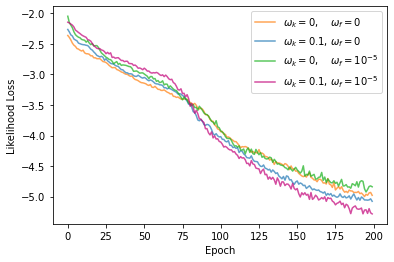

In [82]:
ns=12
ne=212
alpha=0.1
x_epoch = jnp.array([range(ne-ns)]).squeeze()

m1_fkl = jnp.array(all_losses1)[ns:ne,1]
m2_fkl = jnp.array(all_losses2)[ns:ne,1]
m3_fkl = jnp.array(all_losses3)[ns:ne,1]
m4_fkl = jnp.array(all_losses4)[ns:ne,1]

plt.figure(figsize=(6, 4))
plt.plot(x_epoch, m2_fkl, '-', c='#ff7f0e', alpha=0.7, label=r'$\omega_k=0$,    $\omega_f=0$')
plt.plot(x_epoch, m1_fkl, '-', c='#1f77b4', alpha=0.7, label=r'$\omega_k=0.1$, $\omega_f=0$')
plt.plot(x_epoch, m3_fkl, '-', c='#15b01a', alpha=0.7, label=r'$\omega_k=0$,    $\omega_f=10^{-5}$')
plt.plot(x_epoch, m4_fkl, '-', c='#c20078', alpha=0.7, label=r'$\omega_k=0.1$, $\omega_f=10^{-5}$')
plt.xlabel("Epoch")
plt.ylabel("Likelihood Loss")
plt.legend()
#plt.show()
plt.savefig('flow_likelihood.pdf')


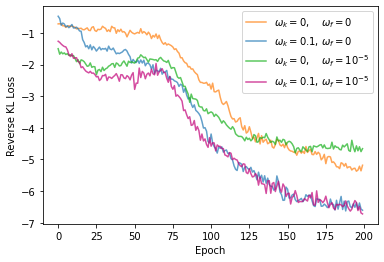

In [83]:
plt.figure(figsize=(6, 4))
m1_rkl = jnp.array(all_losses1)[ns:ne,2]
m2_rkl = jnp.array(all_losses2)[ns:ne,2]
m3_rkl = jnp.array(all_losses3)[ns:ne,2]
m4_rkl = jnp.array(all_losses4)[ns:ne,2]

plt.plot(x_epoch, m2_rkl, '-', c='#ff7f0e', alpha=0.7, label=r'$\omega_k=0$,    $\omega_f=0$')
plt.plot(x_epoch, m1_rkl, '-', c='#1f77b4', alpha=0.7, label=r'$\omega_k=0.1$, $\omega_f=0$')
plt.plot(x_epoch, m3_rkl, '-', c='#15b01a', alpha=0.7, label=r'$\omega_k=0$,    $\omega_f=10^{-5}$')
plt.plot(x_epoch, m4_rkl, '-', c='#c20078', alpha=0.7, label=r'$\omega_k=0.1$, $\omega_f=10^{-5}$')
plt.xlabel("Epoch")
plt.ylabel("Reverse KL Loss")
plt.legend()
#plt.show()
plt.savefig('flow_reverseKL.pdf')

In [84]:
ne=200

In [85]:
rng, key = jax.random.split(rng) 
z1 = jax.random.uniform(key, (10000,14))
x1, _ = model1().apply({'params':all_params1[ne]}, z1, method=model1().forward_bijection)

rng, key = jax.random.split(rng)
z2 = jax.random.uniform(key, (10000,14))
x2, _ = model2().apply({'params':all_params2[ne]}, z2, method=model2().forward_bijection)

rng, key = jax.random.split(rng) 
z3 = jax.random.uniform(key, (10000,14))
x3, _ = model4().apply({'params':all_params3[ne]}, z3, method=model3().forward_bijection)

rng, key = jax.random.split(rng)
z4 = jax.random.uniform(key, (10000,14))
x4, _ = model4().apply({'params':all_params4[ne]}, z4, method=model4().forward_bijection)



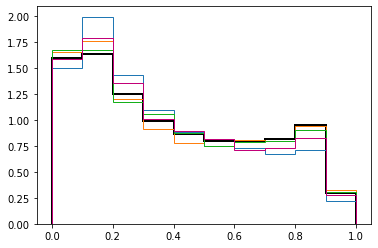

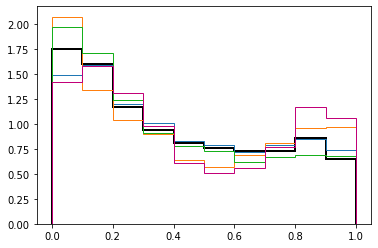

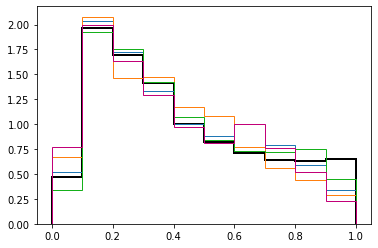

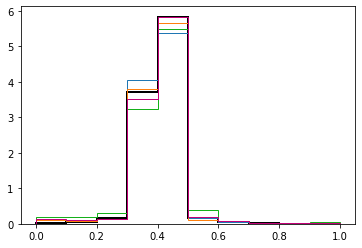

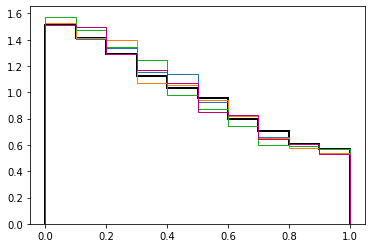

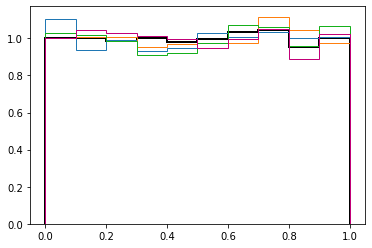

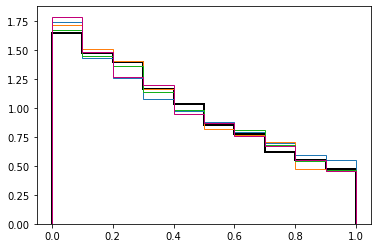

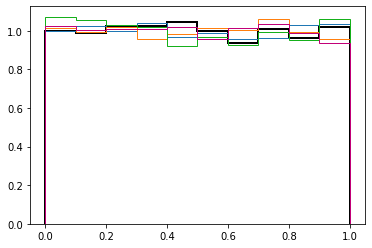

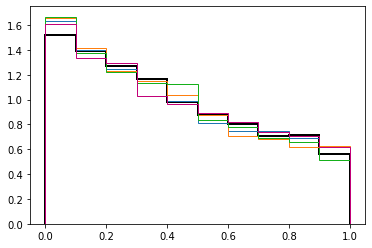

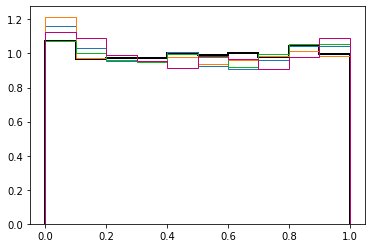

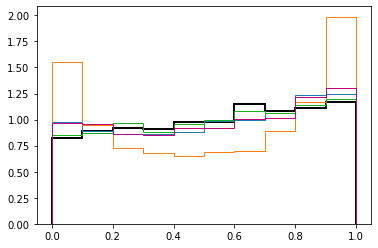

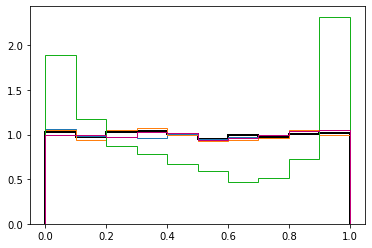

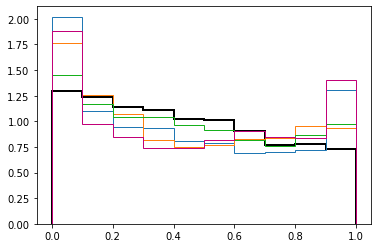

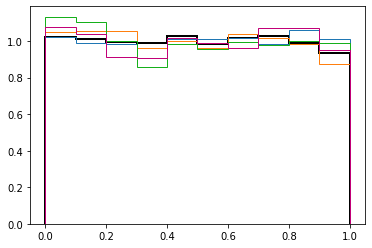

In [86]:
#idx = 1

hbins = np.linspace(0,1,11)


for idx in range(14):
    plt.hist(train_data4[:,idx], bins=hbins, density=True, histtype='step', ec='black', lw=2)
    plt.hist(x1[:,idx], bins=hbins, density=True, histtype='step', ec='#1f77b4')
    plt.hist(x2[:,idx], bins=hbins, density=True, histtype='step', ec='#ff7f0e')
    plt.hist(x3[:,idx], bins=hbins, density=True, histtype='step', ec='#15b01a')
    plt.hist(x4[:,idx], bins=hbins, density=True, histtype='step', ec='#c20078')
    plt.show()




In [ ]:
ne=19
metric = ["total", 'NLL', 'RKL $\\times 0.1$', 'FME $\\times 10^{-6}$']
weight = [1.0, 1.0, 0.1, 1.0e-6]

print('Metric', '&', '$\\omega_{RKL}=0$', '&', '$\\omega_{RKL}=0.1$', '&', '$\\omega_{RKL}=0$',       '&', '$\\omega_{RKL}=0.1$', "\\\\")
print(''      , '&', '$\\omega_{FME}=0$', '&', '$\\omega_{FME}=0$'  , '&', '$\\omega_{FME}=10^{-6}$', '&', '$\\omega_{FME}=10^{-6}$$', '\\\\ \\hline')
for iloss in range(1,4):
    print(metric[iloss], '&', 
          "{:.2f}".format(weight[iloss]*jnp.asarray(losses2[ne][iloss])), '&', 
          "{:.2f}".format(weight[iloss]*jnp.asarray(losses1[ne][iloss])), '&', 
          "{:.2f}".format(weight[iloss]*jnp.asarray(losses3[ne][iloss])), '&', 
          "{:.2f}".format(weight[iloss]*jnp.asarray(losses4[ne][iloss])), '\\\\ \\hline')

# Extra

In [ ]:
"{:.2f}".format(

In [ ]:
# _logp, _gradx_logp = model1().apply({'params':state3.params}, batch, method=model3().val_and_gradx_logprob)
# print(_gradx_logp)
# print(" ")
# me_gradlogp = grad_vector_log_me_jit(batch)
# print(jnp.square(me_gradlogp-_gradx_logp).sum(axis=-1))


# print(jnp.square(me_gradlogp - _gradx_logp).sum(axis=tuple(range(1,batch.ndim))).reshape(-1,1))

In [ ]:
#ff = lambda x: model3().apply({'params':state3.params}, x, method=model3().forward_bijection)
#jax.jax.make_jaxpr(ff)(batch[0:2])

In [ ]:
#jax.jax.make_jaxpr(scalar_log_me)(batch[0])